In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from u_ml import standardize_function, Classifier
from utils import plot_umaps

In [2]:
print(tf.__version__)

2.3.0


In [69]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [73]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
!nvidia-smi

Thu May 26 18:35:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.35       Driver Version: 471.35       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
npath = 'data_out/'
df = pd.read_csv(npath + 'exp1.csv')
df

,_field,_value,_time,i,move,t,tt
0,a0,-0.02,2022-05-25 10:41:18.063544+00:00,1,C,0,0
1,a0,-0.02,2022-05-25 10:41:18.153125+00:00,1,C,90,90
2,a0,-0.02,2022-05-25 10:41:18.244122+00:00,1,C,181,180
3,a0,-0.02,2022-05-25 10:41:18.333530+00:00,1,C,270,270
4,a0,-0.02,2022-05-25 10:41:18.423717+00:00,1,C,360,360
...,...,...,...,...,...,...,...
72496,g2,0.02,2022-05-25 10:50:38.088343+00:00,100,A,1526,1530
72497,g2,-0.01,2022-05-25 10:50:38.177979+00:00,100,A,1616,1620
72498,g2,0.01,2022-05-25 10:50:38.313189+00:00,100,A,1751,1710
72499,g2,-0.02,2022-05-25 10:50:38.403083+00:00,100,A,1841,1800


In [28]:
# dataset horizontal y completar nan con interpolación
dfa = df.groupby(['i', 'tt', 'move', '_field']).agg('_value').mean().reset_index()
dfp = dfa.pivot(index=['i', 'tt', 'move'], columns=['_field'], values='_value').reset_index()
dfp1 = dfp.groupby(['i']).apply(lambda group: group.interpolate())
dfp1 = dfp1.fillna(0)
dfp1['class'] = dfp1.move.astype('category').cat.codes
dfp1

_field,i,tt,move,a0,a1,a2,c0,c1,c2,f0,f1,f2,g0,g1,g2,class
0,1,-90,C,0.00,0.00,0.00,2.01,-31.65,32.90,0.00,0.00,0.00,0.0,0.00,0.00,2
1,1,0,C,-0.02,-1.00,0.00,2.12,-31.76,32.78,-1.57,0.02,-1.47,0.0,-0.01,0.00,2
2,1,90,C,-0.02,-0.99,0.00,2.11,-31.89,32.79,-1.57,0.02,-1.47,0.0,0.00,0.00,2
3,1,180,C,-0.02,-0.99,0.01,2.10,-31.72,32.78,-1.57,0.02,-1.47,0.0,0.00,0.00,2
4,1,270,C,-0.02,-0.99,0.00,1.98,-31.61,32.91,-1.57,0.02,-1.47,0.0,0.00,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6290,100,1620,A,0.00,-0.98,0.01,-2.06,-33.25,23.00,-1.60,0.00,-1.68,0.0,0.00,-0.01,0
6291,100,1710,A,0.00,-0.98,0.01,-2.09,-33.16,23.10,-1.60,0.00,-1.68,0.0,-0.01,0.01,0
6292,100,1800,A,0.00,-0.98,0.01,-2.06,-33.39,23.30,-1.60,0.00,-1.68,0.0,-0.01,-0.02,0
6293,100,1890,A,-0.03,-1.00,0.02,-1.91,-33.39,23.80,-1.60,0.00,-1.68,0.0,0.02,0.01,0


# 1. UMAP 

In [36]:
import umap
features = list(set(dfp1.columns) - {'_field', 'i', 'tt', 'move', 'class'})
datas = standardize_function(dfp1[features])
datas

_field,a2,c2,a1,f1,c1,a0,c0,f2,g1,g2,f0,g0
0,0.203280,1.101428,2.318641,-0.590508,-0.498606,0.450529,0.433829,2.437811,0.024601,-0.002913,5.423144,-0.029174
1,0.203280,1.081287,-0.318208,-0.534492,-0.507218,0.399504,0.445891,0.139274,0.011576,-0.002913,0.425644,-0.029174
2,0.203280,1.082966,-0.291840,-0.534492,-0.517395,0.399504,0.444794,0.139274,0.024601,-0.002913,0.425644,-0.029174
3,0.229361,1.081287,-0.291840,-0.534492,-0.504086,0.399504,0.443698,0.139274,0.024601,-0.002913,0.425644,-0.029174
4,0.203280,1.103107,-0.291840,-0.534492,-0.495475,0.399504,0.430539,0.139274,0.024601,-0.002913,0.425644,-0.029174
...,...,...,...,...,...,...,...,...,...,...,...,...
6290,0.229361,-0.560232,-0.265471,-0.590508,-0.623864,0.450529,-0.012472,-0.189088,0.024601,-0.014151,0.330151,-0.029174
6291,0.229361,-0.543447,-0.265471,-0.590508,-0.616818,0.450529,-0.015762,-0.189088,0.011576,0.008325,0.330151,-0.029174
6292,0.229361,-0.509878,-0.265471,-0.590508,-0.634824,0.450529,-0.012472,-0.189088,0.011576,-0.025388,0.330151,-0.029174
6293,0.255441,-0.425956,-0.318208,-0.590508,-0.634824,0.373991,0.003976,-0.189088,0.050650,0.008325,0.330151,-0.029174


## a) a pelo

In [15]:
reducer = umap.UMAP(verbose=True)
embedding = reducer.fit_transform(datas)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu May 26 18:39:29 2022 Finding Nearest Neighbors
Thu May 26 18:39:29 2022 Building RP forest with 9 trees
Thu May 26 18:39:29 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Thu May 26 18:39:40 2022 Finished Nearest Neighbor Search
Thu May 26 18:39:43 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu May 26 18:39:50 2022 Finished embedding


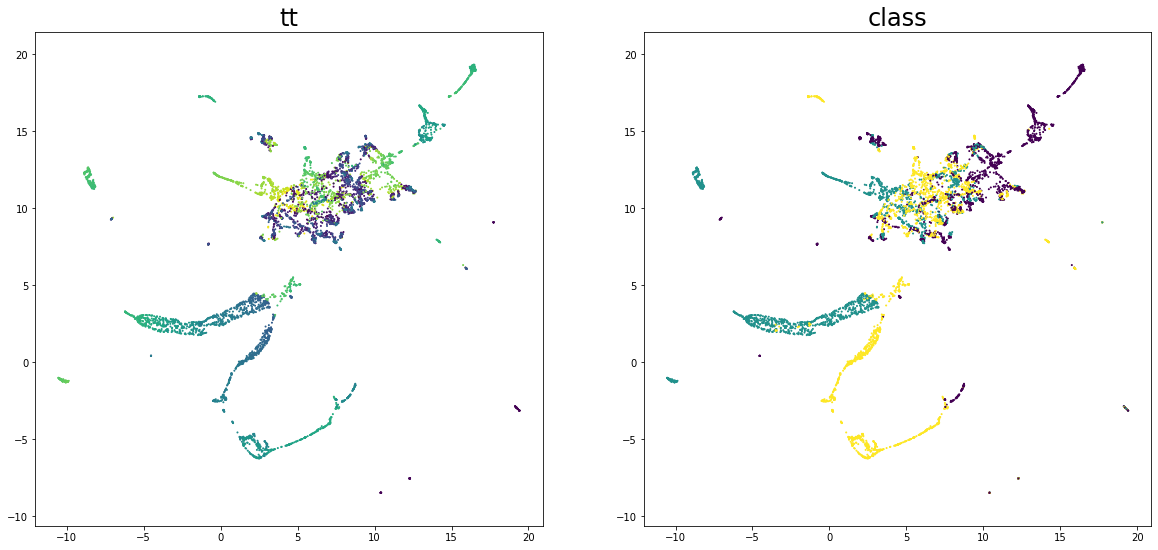

In [13]:
plot_umaps(embedding, dfp1)

## b) supervisado

In [44]:
reducer2 = umap.UMAP(verbose=True)
embedding2 = reducer.fit_transform(datas, y=dfp1['class'])

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu May 26 19:08:21 2022 Finding Nearest Neighbors
Thu May 26 19:08:21 2022 Building RP forest with 9 trees
Thu May 26 19:08:21 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Thu May 26 19:08:21 2022 Finished Nearest Neighbor Search
Thu May 26 19:08:21 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu May 26 19:08:30 2022 Finished embedding


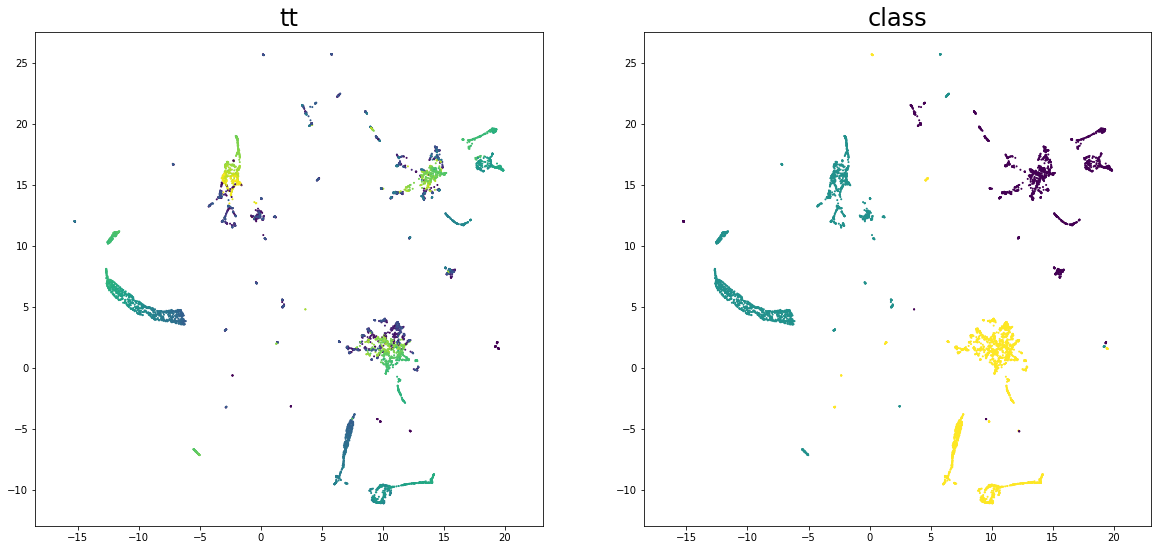

In [45]:
plot_umaps(embedding2, dfp1)

In [16]:
dfp

_field,i,tt,move,a0,a1,a2,c0,c1,c2,f0,f1,f2,g0,g1,g2
0,1,-90,C,NaN,NaN,NaN,2.01,-31.65,32.90,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,C,-0.02,-1.00,0.00,2.12,-31.76,32.78,-1.57,0.02,-1.47,0.0,-0.01,0.00
2,1,90,C,-0.02,-0.99,0.00,2.11,-31.89,32.79,-1.57,0.02,-1.47,0.0,0.00,0.00
3,1,180,C,-0.02,-0.99,0.01,2.10,-31.72,32.78,-1.57,0.02,-1.47,0.0,0.00,0.00
4,1,270,C,-0.02,-0.99,0.00,1.98,-31.61,32.91,-1.57,0.02,-1.47,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6290,100,1620,A,0.00,-0.98,0.01,-2.06,-33.25,23.00,-1.60,0.00,-1.68,0.0,0.00,-0.01
6291,100,1710,A,NaN,NaN,NaN,-2.09,-33.16,23.10,NaN,NaN,NaN,0.0,-0.01,0.01
6292,100,1800,A,0.00,-0.98,0.01,-2.06,-33.39,23.30,-1.60,0.00,-1.68,0.0,-0.01,-0.02
6293,100,1890,A,-0.03,-1.00,0.02,-1.91,-33.39,23.80,-1.60,0.00,-1.68,0.0,0.02,0.01


In [41]:
# get last 58 timestamps excluding group 100  #### WHY 57?
dfp2 = dfp1[dfp1.i != 100]
dfp2 = dfp2.groupby("i").apply(lambda x: x.iloc[-57:])
dfp2 = dfp2.rename(columns={'i': 'ii'})
dfp2

_field   ii    tt move    a0    a1    a2      c0      c1      c2    f0    f1  \
i                                                                              
1  3      1   180    C -0.02 -0.99  0.01  2.1000 -31.720  32.780 -1.57  0.02   
   4      1   270    C -0.02 -0.99  0.00  1.9800 -31.610  32.910 -1.57  0.02   
   5      1   360    C -0.02 -1.00  0.01  1.9300 -31.720  33.200 -1.57  0.02   
   6      1   450    C -0.02 -0.99  0.00  2.0000 -31.770  32.950 -1.57  0.02   
   7      1   540    C -0.02 -1.00  0.01  2.0100 -31.830  33.160 -1.57  0.02   
...      ..   ...  ...   ...   ...   ...     ...     ...     ...   ...   ...   
99 6267  99  5130    A  0.02 -1.08  0.01  0.7375 -33.725  24.325 -1.62  0.00   
   6268  99  5220    A  0.03 -0.98  0.04  0.2950 -33.570  24.110 -1.62  0.01   
   6269  99  5310    A -0.02 -0.99 -0.06 -0.2500 -33.590  23.900 -1.62  0.00   
   6270  99  5400    A  0.01 -1.02  0.07 -0.6400 -33.560  23.800 -1.62  0.01   
   6271  99  5490    A  0.01 -1.02  0.07 -0.6400 -33.560  23.800 -1.62  0.00   

_field     f2    g0    g1    g2  class  
i                                       
1  3    -1.47  0.00  0.00  0.00      2  
   4    -1.47  0.00  0.00  0.00      2  
   5    -1.47  0.00  0.00  0.00      2  
   6    -1.47  0.00  0.00  0.00      2  
   7    -1.47  0.00  0.00  0.00      2  
...       ...   ...   ...   ...    ...  
99 6267 -1.73  0.00 -0.10  0.04      0  
   6268 -1.72  0.02  0.08 -0.02      0  
   6269 -1.72 -0.02 -0.08  0.02      0  
   6270 -1.71  0.01  0.04 -0.03      0  
   6271 -1.71  0.01  0.04 -0.03      0  

[5643 rows x 16 columns]

<AxesSubplot:xlabel='ii'>

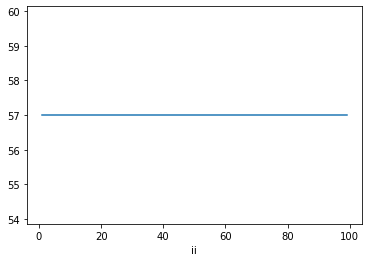

In [42]:
dfp2.groupby('ii').count()['tt'].plot()

In [46]:
target = np.asarray(pd.get_dummies(dfp2['class'].values)).reshape((-1, 57, 3))
target.shape

(99, 57, 3)

In [48]:
target[1]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [49]:
data = np.asarray(dfp2[features]).reshape((-1, 57, 12))
data.shape

(99, 57, 12)

In [50]:
data[1]  # tensor

array([[ 2.0000e-02,  3.1990e+01, -9.7000e-01,  1.0000e-01, -3.1520e+01,
        -3.0000e-02,  1.4300e+00, -1.5500e+00,  1.0000e-02, -7.0000e-02,
        -1.6600e+00,  2.0000e-02],
       [-1.0000e-02,  3.1990e+01, -1.0100e+00,  9.0000e-02, -3.1420e+01,
        -4.0000e-02,  1.3800e+00, -1.5500e+00, -1.0000e-02,  6.0000e-02,
        -1.6600e+00, -2.0000e-02],
       [-2.0000e-02,  3.1700e+01, -9.6000e-01,  1.0000e-01, -3.1400e+01,
        -3.0000e-02,  1.3700e+00, -1.5500e+00, -1.0000e-02, -8.0000e-02,
        -1.6600e+00,  4.0000e-02],
       [ 3.0000e-02,  3.1910e+01, -1.0000e+00,  9.0000e-02, -3.1430e+01,
        -3.0000e-02,  1.3700e+00, -1.5500e+00,  0.0000e+00,  7.0000e-02,
        -1.6500e+00, -3.0000e-02],
       [-1.0000e-02,  3.1950e+01, -9.5000e-01,  9.0000e-02, -3.1420e+01,
        -2.0000e-02,  1.4300e+00, -1.5500e+00,  0.0000e+00, -6.0000e-02,
        -1.6500e+00,  1.0000e-02],
       [ 0.0000e+00,  3.1830e+01, -9.6000e-01,  9.0000e-02, -3.1500e+01,
        -4.0000e-02,  

In [23]:
X_train, y_train = data[:60], target[:60]
X_val, y_val = data[60:80], target[60:80]
X_test, y_test = data[80:], target[80:]

In [54]:
LR = .001  # learning rate
nn_epochs = 15
nn_batch_size = 16

shape_ = (None, X_train.shape[2])  # input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
n_out = 3
model = Classifier(shape_, n_out, LR)

In [55]:
model.fit(X_train, y_train,
          epochs=nn_epochs,
          batch_size=nn_batch_size, verbose=2,
          validation_data=(X_val, y_val))

preds_test = model.predict(X_test)

Epoch 1/15
4/4 - 2s - loss: 6.9425 - accuracy: 0.4126 - val_loss: 4.5191 - val_accuracy: 0.4474
Epoch 2/15
4/4 - 0s - loss: 6.2906 - accuracy: 0.4184 - val_loss: 4.7440 - val_accuracy: 0.5430
Epoch 3/15
4/4 - 0s - loss: 5.7094 - accuracy: 0.4047 - val_loss: 3.6985 - val_accuracy: 0.5658
Epoch 4/15
4/4 - 0s - loss: 5.2182 - accuracy: 0.5061 - val_loss: 3.5215 - val_accuracy: 0.5754
Epoch 5/15
4/4 - 0s - loss: 3.7682 - accuracy: 0.4842 - val_loss: 2.5328 - val_accuracy: 0.4447
Epoch 6/15
4/4 - 0s - loss: 1.7335 - accuracy: 0.5693 - val_loss: 1.5642 - val_accuracy: 0.5728
Epoch 7/15
4/4 - 0s - loss: 1.7721 - accuracy: 0.5231 - val_loss: 1.1492 - val_accuracy: 0.5342
Epoch 8/15
4/4 - 0s - loss: 1.0912 - accuracy: 0.6193 - val_loss: 0.8714 - val_accuracy: 0.7053
Epoch 9/15
4/4 - 0s - loss: 0.9577 - accuracy: 0.6898 - val_loss: 0.2318 - val_accuracy: 0.9219
Epoch 10/15
4/4 - 0s - loss: 0.3880 - accuracy: 0.7757 - val_loss: 0.6639 - val_accuracy: 0.6895
Epoch 11/15
4/4 - 0s - loss: 0.2720 - a

Ha acertado 100%:

In [91]:
preds_test.shape

(19, 57, 3)

In [88]:
np.mean(preds_test, axis=1)

array([[6.6166528e-08, 9.9997693e-01, 2.3101975e-05],
       [4.1924875e-02, 6.0166157e-04, 9.5747358e-01],
       [5.8845615e-01, 1.5406274e-04, 4.1138980e-01],
       [6.4185590e-01, 1.2371392e-04, 3.5802040e-01],
       [2.8755755e-08, 9.9998748e-01, 1.2576818e-05],
       [4.3002613e-02, 5.8672088e-04, 9.5641071e-01],
       [6.1576104e-01, 1.5096195e-04, 3.8408792e-01],
       [7.1904939e-01, 1.0001042e-04, 2.8085074e-01],
       [1.1787871e-01, 4.5106857e-04, 8.8167012e-01],
       [7.4766980e-08, 9.9997723e-01, 2.2772287e-05],
       [4.6591122e-02, 7.6951942e-04, 9.5263922e-01],
       [5.7704131e-08, 9.9998027e-01, 1.9785883e-05],
       [4.2535864e-02, 1.0258335e-03, 9.5643842e-01],
       [6.4302546e-01, 1.4188104e-04, 3.5683259e-01],
       [6.9358492e-01, 1.2711344e-04, 3.0628800e-01],
       [8.8188912e-08, 9.9998003e-01, 1.9937390e-05],
       [5.1296789e-02, 8.8408688e-04, 9.4781899e-01],
       [6.4990896e-01, 1.5579014e-04, 3.4993514e-01],
       [6.6589183e-01, 1.593

In [74]:
l_pred=np.argmax(np.mean(preds_test, axis=1), axis=1)
l_pred

array([1, 2, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0],
      dtype=int64)

In [75]:
l_test=np.argmax(np.mean(y_test, axis=1), axis=1)
l_test

array([1, 2, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0],
      dtype=int64)

In [78]:
import u_ml as u

oi


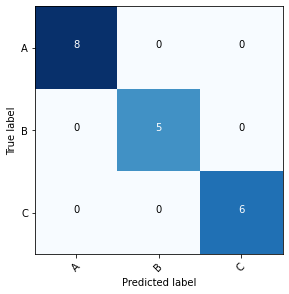

In [84]:
u.pinta_cm2(l_test, l_pred, ['A', 'B', 'C'])

In [85]:
y_test

array([[[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]],

       [[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       ...,

       [[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]], dtype=uint8)